# Course-Skill Graph Creation for the Master's Program in Business Informatics University of Mannheim
This notebook contains the code to create the Course-Skill Graph for the Master's Program in Business Informatics of the University of Mannheim.

The notebook is divided into the following sections:
1. Imports
2. Graph Creation

## 1. Imports

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3

## 2. Graph Creation
### 2.1 Extract Course Tables from Module Handbooks
This part covers the extraction of the relevant courses from the module catalogs. The courses are extracted as Pandas DataFrames and stored in csv files.

In [2]:
#Get relevant courses from the course overview in the main module catalog
relevant_courses = te.get_relevant_courses("../02_Ressources/MK_MSc_Wifo_neue_PO_2020_21_CourseOverview.pdf")

#Get courses from the module catalogs
courses = te.get_courses("../02_Ressources/MK_MSc_Wifo_neue_PO_2020_21_Courses.pdf")
paths = ["../02_Ressources/Modulkatalog_MMM_Deutsch_abHWS2020.pdf"]
end_cells = [r"Range of application|Verwendbarkeit"]
coordinates = [[0,0]]
bwl_range = [["ACC", "TAX", "FIN", "MAN", "MKT", "OPM"], ["5", "6"]]
courses.extend(te.get_additional_courses(relevant_courses, paths, end_cells, coordinates, bwl_range))

C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (529.9550507738653, 530.0030525768653) does not lie in column range (71.265635564094, 528.1335517976622)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (529.6098477449448, 529.6578495479448) does not lie in column range (71.20564811265618, 528.2535276158808)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (540.621295177622, 540.669296980622) does not lie in column range (71.265635564094, 538.6914238008867)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (528.592483966372, 528.640485769372) does not lie in column range (71.265635564094, 528.1335517976622)
  warnings.warn(


In [ ]:
#Everything in this cell is commented out to avoid the manually edited csv files from being overwritten

#Export course DataFrames to csv files
#courses = te.post_fixes(courses)

#index = 0
#for course in courses:
    #name = "../03_Courses/" + "Course" + str(index) + ".xlsx"
    #course.to_excel(name, index=False)
    #index += 1

In [16]:
#Import courses from the manually edited csv files and store them as DataFrames

courses = []
for i in range(0,173):
    path = "../03_Courses/Course" + str(i) + ".xlsx"
    df = pd.read_excel(path, dtype=str).fillna('')
    courses.append(df)

### 2.2 Creation of Nodes & Edges
This part covers the creation of the nodes and edges of the Course-Skill Graph.

In [17]:
#Create an empty NetworkX Graph
G = nx.DiGraph()

#Extract course names together with the ECTS points they credit and their offering cycle from the DataFrames and store the information in a list
course_nodes = gc.getCourseNodes(courses)

#Import the names of the skill nodes and store them in a list
knowledge_nodes = pd.read_excel("../04_Graph/knowledgeAreas.xlsx").values.tolist()

#Import the manually created course -> skill edges of the graph as a DataFrame with the columns "Outgoing" and "Incoming"
edges_df = pd.read_excel("../04_Graph/edges.xlsx")

#Translate the DataFrame representing the edges into a list
edges = edges_df.values.tolist()

In [18]:
#Create the course nodes and add them to the graph
for node in course_nodes:
    G.add_node(node[0], ECTS=node[1], offering_cycle=node[2], color="grey", type="course", active = False)

#Create the skill nodes and add them to the graph
for i in range(len(knowledge_nodes)):
    if i <= 16:
        G.add_node(knowledge_nodes[i][0], color="blue", type="skill", active = False)
    elif i > 16 and i <= 22:
        G.add_node(knowledge_nodes[i][0], color="green", type="skill", active = False)
    else:
        G.add_node(knowledge_nodes[i][0], color="red", type="skill", active = False)

In [19]:
#Add the course -> skill edges to the graph
for edge in edges:
   G.add_edge(edge[0], edge[1], active = False)

#Create the skill -> course edges and all edges representing prerequisite relationships
additional_edges, prerequiste_nodes = gc.complete_edges(courses, edges_df)

#Add prerequiste nodes to the graph
for node in prerequiste_nodes:
    G.add_node(node[0], color = node[1], type = node[2], subtype = node[3], amount = node[4], active = False)

#Add skill -> course edges and all edges representing prerequisite relationships to the graph
for edge in additional_edges:
    if len(edge) <= 2:
        G.add_edge(edge[0], edge[1], active = False)
    else:
        G.add_edge(edge[0], edge[1], weight = edge[2], active = False)

In [20]:
#Set weights for parallel prerequisite relationships
G.edges["FIN 540 Corporate Finance I - Lecture (Capital Structure, Cost of Capital and Valuation)",
"FIN 541 Corporate Finance I - Case Study (Capital Structure, Cost of Capital and Valuation)"]["weight"] = 2

G.edges["IS 512 IT Management in the Digital Age", "IS 513 Applied IT Management in the Digital Age"]["weight"] = 2

G.edges["IS 615 Design Thinking and Lean Development in Enterprise Software Development", 
"IS 613 Applied Project in Design Thinking and Lean Software Development"]["weight"] = 2

G.edges["MIN 10", "OPM 601 Supply Chain Management"]["weight"] = 2

G.edges["MIN 11", "OPM 661 Business Analytics: Robust Planning in Stochastic Systems"]["weight"] = 2

G.edges["MIN 12", "OPM 682 Revenue Management"]["weight"] = 2

In [21]:
#Add complex prerequisite relationships

#ACC 626 
G.add_node("MIN 13", color = "white", type = "prerequisite", subtype = "MIN", amount = 1, active = False)
G.add_node("MIN 14", color = "white", type = "prerequisite", subtype = "MIN", amount = 2, active = False)
G.add_edge("MIN 13", "ACC 626 Transaction Accounting", weight = 1, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 13", weight = 1, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 13", weight = 1, active = False)
G.add_edge("MIN 14", "MIN 13", weight = 1, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 14", weight = 1, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 14", weight = 1, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 14", weight = 1, active = False)

#ACC 628 
G.add_node("MIN 15", color = "white", type = "prerequisite", subtype = "MIN", amount = 1, active = False)
G.add_node("MIN 16", color = "white", type = "prerequisite", subtype = "MIN", amount = 2, active = False)
G.add_edge("MIN 15", "ACC 628 Selected Issues in IFRS Accounting", weight = 1, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 15", weight = 1, active = False)
G.add_edge("MIN 16", "MIN 15", weight = 1, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 16", weight = 1, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 16", weight = 1, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 16", weight = 1, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 16", weight = 1, active = False)

#ACC 632 
G.add_node("MIN 17", color = "white", type = "prerequisite", subtype = "MIN", amount = 1, active = False)
G.add_node("MIN 18", color = "white", type = "prerequisite", subtype = "MIN", amount = 2, active = False)
G.add_edge("MIN 17", "ACC 632 Konzernrechnungslegungspraxis", weight = 1, active = False)
G.add_edge("ACC 530 Group Accounting", "MIN 17", weight = 1, active = False)
G.add_edge("MIN 18", "MIN 17", weight = 1, active = False)
G.add_edge("ACC 510 Jahresabschluss", "MIN 18", weight = 1, active = False)
G.add_edge("ACC 520 IFRS Accounting and Capital Markets", "MIN 18", weight = 1, active = False)
G.add_edge("ACC 540 Financial Statement Analysis & Equity Valuation", "MIN 18", weight = 1, active = False)
G.add_edge("ACC 560 Managerial Accounting", "MIN 18", weight = 1, active = False)

In [22]:
#Quality Checks for attribute values

#for node, data in G.nodes(data=True):
    #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(data.get('offering_cycle'))
    #if not (data.get('offering_cycle') == "FWS" or data.get('offering_cycle') =="SSS" or data.get('offering_cycle') == "Continuously"):
        #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(f"Knoten {node}: name = {data.get('ECTS')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    if "OR 3" in outgoing or "OR 3" in ingoing:
#        print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

<function matplotlib.pyplot.show(close=None, block=None)>

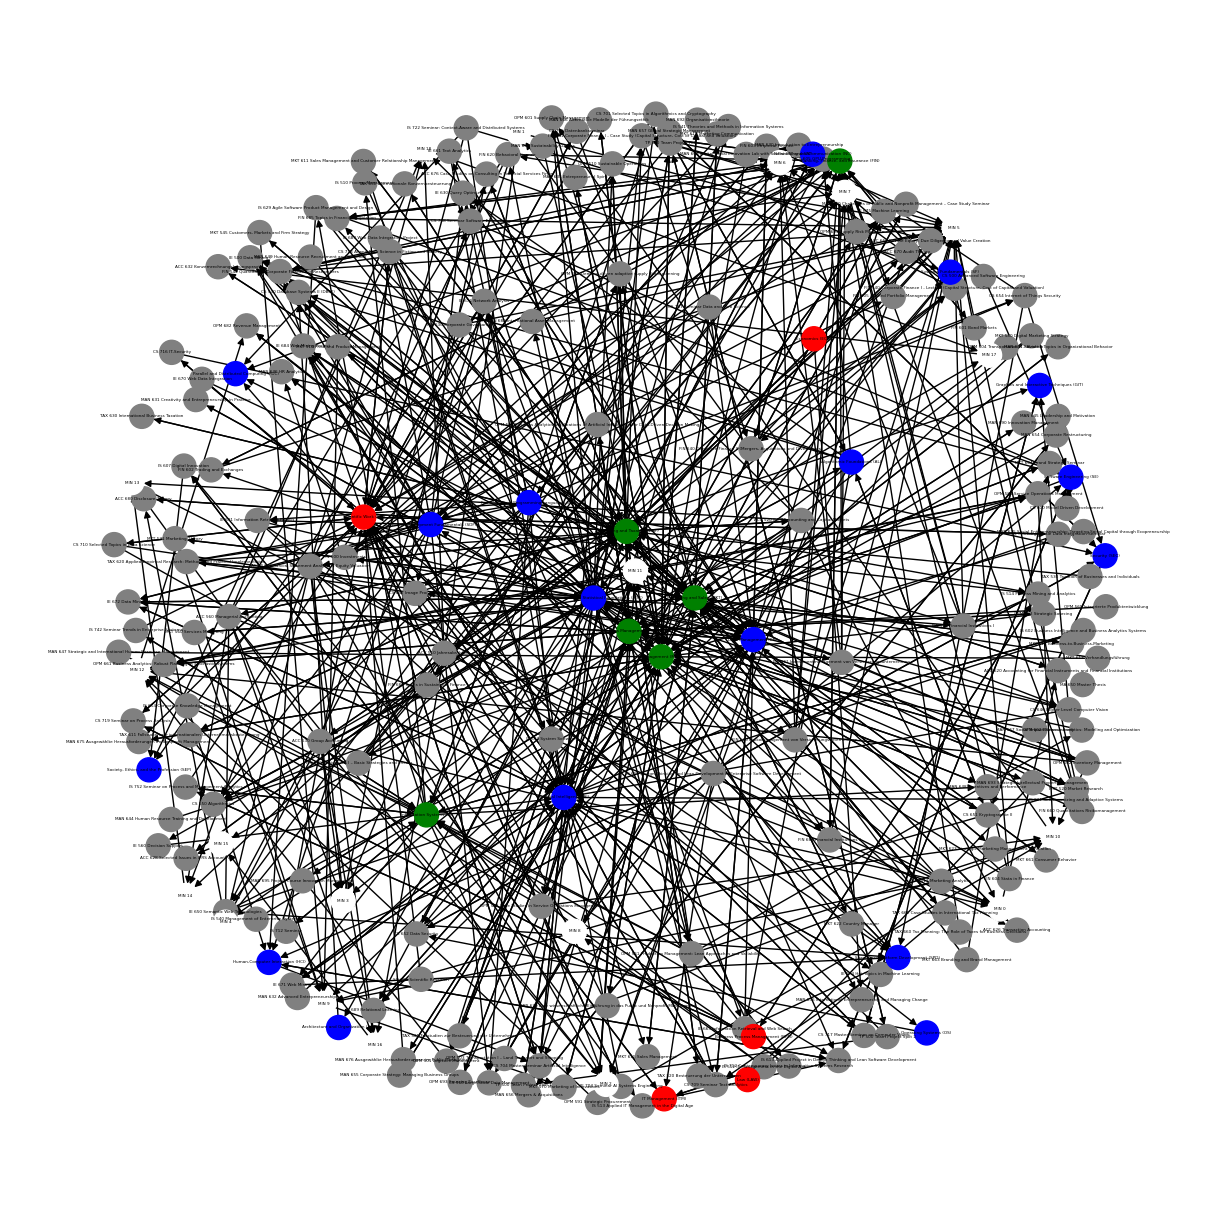

In [23]:
#Export Course-Skill Graph as a PDF file

pos = nx.spring_layout(G, k=1) 
plt.figure(figsize=(12, 12))

node_colors = [G.nodes[node]['color'] for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=3)

plt.savefig("Outputs/Course-Skill_Master.pdf", format="pdf") 
plt.show

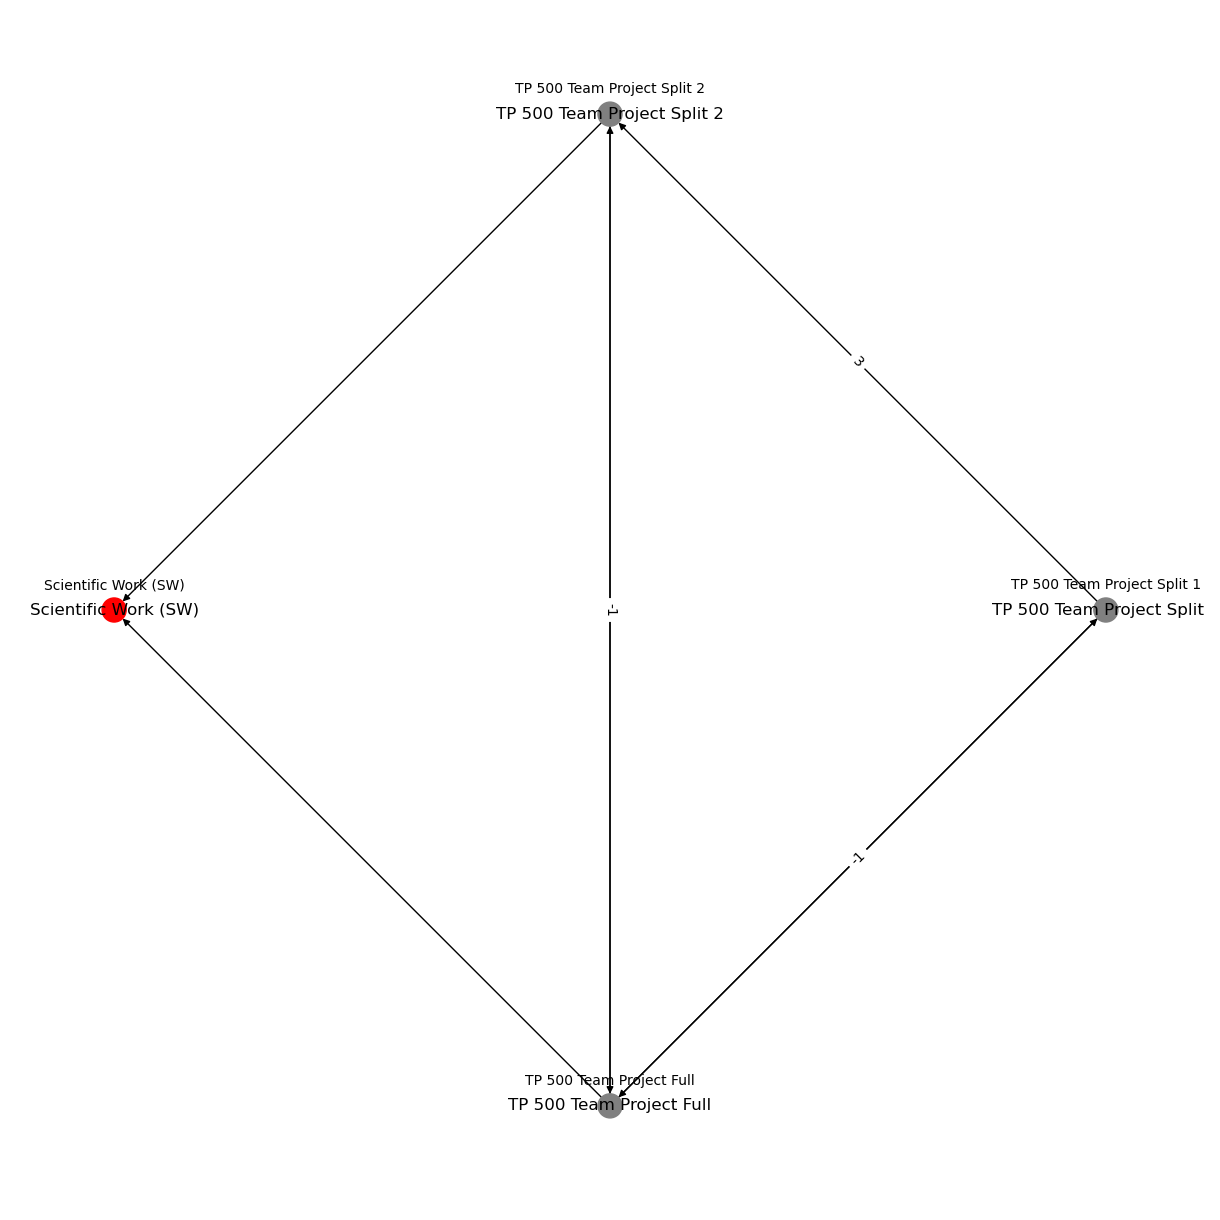

In [24]:
#Script for visualizing individual nodes

#Insert Name of the node to visualize
node_id = 'ACC 510'
node_id = 'TP 500 Team Project Full'

#Get incoming and outgoing edges of the node
incoming_nodes = [n for n in G.predecessors(node_id)] 
outgoing_nodes = [n for n in G.successors(node_id)] 

#Uncomment the desired edges that should be included in the visualization
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

#Create the plot
subgraph = G.subgraph(subgraph_nodes)
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(12, 12))

node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05 
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.savefig("Outputs/Node_Visualization.pdf", format="pdf")
plt.show()

In [25]:
#Assign the course pool attribute
gc.createPools(G)

#Check if all course nodes are assigned to a course pool
for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        print(node + ": " + G.nodes[node].get("pool", "No pool"))

CS 500 Advanced Software Engineering: Fundamentals Computer Science
CS 530 Database Systems II (DBSII): Fundamentals Computer Science
CS 550 Algorithmics: Fundamentals Computer Science
CS 560 Large-Scale Data Management: Fundamentals Computer Science
IE 500 Data Mining I: Fundamentals Computer Science
IE 560 Decision Support: Fundamentals Computer Science
CS 600 Model Driven Development: Specialization Courses
CS 605 GPU Programming: Specialization Courses
CS 646 Higher Level Computer Vision: Specialization Courses
CS 647 Image Processing: Specialization Courses
CS 651 Kryptographie II: Specialization Courses
CS 652 Data Security: Specialization Courses
CS 654 Internet of Things Security: Specialization Courses
IE 630 Query Optimization: Specialization Courses
IE 650 Semantic Web Technologies: Specialization Courses
IE 661 Text Analytics: Specialization Courses
IE 663 Information Retrieval and Web Search: Specialization Courses
IE 670 Web Data Integration: Specialization Courses
IE 671

### 2.3 Matching Graph Names to Database Names
This part covers the process of matching the course names in the module catalog / graph to the course names in the database.

In [26]:
#Match course names between graph and database

#Create helper database with the course names from the database
df_courseNames = pd.read_csv("../02_Ressources/DB_CourseNames.csv", delimiter=";", encoding="latin1")
conn = sqlite3.connect('Course_Matching/DB_CourseNames.db')
cursor = conn.cursor()
df_courseNames.to_sql('course_names', conn, if_exists='replace', index=False)

#Create a list with all course names in the graph. Already existing mappings are applied
graph_courseNames = []
for course in courses:
    graph_courseNames.append(gc.mapGraphToDB_courseName(course))

matching_results = []

#Use SQL Query similar to the ones used in the weighting scripts to test if the mapping is sufficient
for graph_courseName in graph_courseNames:
    query = "SELECT Course FROM course_names WHERE ? LIKE Course || '%'" 
    cursor.execute(query, (graph_courseName,))
    results = cursor.fetchall()
    
    results_string = ', '.join([str(result[0]) for result in results])
    matching_results.append(graph_courseName + " matches: " + results_string)
    
#Print courses without a match
for course_match in matching_results:
    if re.match(r".*matches: $", course_match):
        print(course_match)

conn.close()

MA 650 Master Thesis matches: 
ACC 530 Group Accounting matches: 
ACC 560 Managerial Accounting matches: 
ACC 626 Transaction Accounting matches: 
ACC 628 Selected Issues in IFRS Accounting matches: 
ACC 632 Konzernrechnungslegungspraxis matches: 
ACC 662 Private Equity: Due Diligence and Value Creation matches: 
ACC 676 Case Studies on Consulting in Financial Services Firms matches: 
ACC 680 Disclosure Theory matches: 
TAX 611 Fallstudien zur internationalen Unternehmensbesteuerung matches: 
TAX 620 Applied Empirical Research: Methods and Practical Implementation matches: 
TAX 630 International Business Taxation matches: 
TAX 631 Internationale Konzernbesteuerung matches: 
TAX 661 Case Studies in International Tax Planning matches: 
FIN 542 Quantitative Corporate Finance for Researchers matches: 
FIN 603 Empirical Finance matches: 
FIN 604 Stata in Finance matches: 
FIN 605 Applied Portfolio Management matches: 
FIN 640 Corporate Finance II (Mergers, Acquisitions and Divestitures) mat

### 2.4 Weight Course -> Skill Edges
This part covers the weighting of all course -> skill edges. The scripts were run externally because of restricted access to the database. Therefore this part only contains the creation of the Course-Skill Graph version needed to run the scripts and the import of the corresponding results.

In [27]:
#Export graph to run weighting scripts externally
nx.write_graphml(G, "Outputs/CourseSkillGraph_Master.graphml")

In [28]:
#Import Results of the weighting process
course_skill_weights_df = pd.read_excel("../04_Graph/CourseSkillWeights_Master.xlsx")
course_skill_weights = course_skill_weights_df.values.tolist()

for weight in course_skill_weights:
    #Normalize grade differences represented by the weights
    G.edges[weight[1], weight[2]]["weight"] = weight[0]/100


### 2.5 Weight Skill -> Course Edges
This part covers the weighting of all skill -> course edges. Similar to the course -> skill edges the scripts were run externally because of restricted access to the database. Therefore this part only contains the creation of the Course-Skill Graph version needed to run the scripts and the import of the corresponding results.

In [29]:
#Export graph to run weighting scripts externally
nx.write_graphml(G, "Outputs/CourseSkillGraph_Master.graphml")

In [30]:
#Import Results of the weighting process
skill_course_weights_df = pd.read_excel("../04_Graph/SkillCourseWeights_Master.xlsx")
skill_course_weights = skill_course_weights_df.values.tolist()

for weight in skill_course_weights:
    G.edges[weight[1], weight[2]]["weight"] = weight[0]

In [31]:
#Export final graph
nx.write_graphml(G, "../04_Graph/CourseSkillGraph_Master.graphml")